In [1]:
import requests
import pandas as pd
import io
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import math  
pd.set_option('display.max_columns', None)  # Afficher toutes les colonnes sans tronquer
pd.set_option('display.max_rows', None)  
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split


In [2]:




def get_data(url,path_file,url_2,columns):
    # Utilisez la fonction requests.get() pour récupérer le contenu de l'URL
    response = requests.get(url)
    # Vérifiez que la requête a réussi
    response.raise_for_status()
    # Lisez le contenu de la réponse sous forme de CSV et convertissez-le en DataFrame
    df_nb_veh = pd.read_json(io.StringIO(response.text), encoding='utf-8')

    # information departement
    df_dep = pd.read_csv(path_file,dtype={"code_departement": str}, encoding='utf-8')


    # Utilisez la fonction requests.get() pour récupérer le contenu de l'URL
    response_2 = requests.get(url_2)

    # Vérifiez que la requête a réussi
    response_2.raise_for_status()

    # Lisez le contenu de la réponse sous forme de CSV et convertissez-le en DataFrame
    df_chrg = pd.read_csv(io.StringIO(response_2.text),low_memory=False
                    ,parse_dates=["date_mise_en_service"]
                    ,dtype={"consolidated_code_postal": str
                        }, encoding='utf-8')\
    .sort_values(['id_pdc_itinerance', 'last_modified'])
    df_chrg = df_chrg[columns]
    
    return df_nb_veh, df_dep, df_chrg


In [3]:

def process_func(df_chrg):

    # Définir la date d'aujourd'hui
    today = pd.Timestamp.today().normalize()

    df_process = df_chrg.copy()
    # On ne peut pas avoir une puissance >2Mega Watt pour un point de charge 

    df_process.puissance_nominale = df_chrg.puissance_nominale.apply(
        lambda x: x if x < 2000 else x / 1000
    )

    df_process = df_process[(df_process['date_mise_en_service'] >= '2015-01-01') &
                             (df_process['date_mise_en_service'] <= today)]  

    df_process = df_process.sort_values(["id_pdc_itinerance", "last_modified"])

    # id_pdc_itinerance represente l'ID du point de charge qui est supposé etre unique
    df_process = df_process.drop_duplicates("id_pdc_itinerance", keep="last")

    # nouvelle colonne departement
    df_process["code_departement"] = df_process["consolidated_code_postal"].str[:2]
    return df_process



In [4]:
def agg_func(df):
    # Créer un nouveau DataFrame avec l'agrégation par codgeo
    df_agg = df.groupby('codgeo')['nb_vp_rechargeables_el'].mean().reset_index()
    print(df_agg.head())

    return df_agg



In [5]:
def join_func(df_chrg,df_dep,df_agg):
    df_chrg = pd.merge(df_chrg,df_dep, how='left', on='code_departement')
    df_join = df_chrg.merge(df_agg, how='left', left_on='code_insee_commune', right_on='codgeo')

    return df_join

In [6]:
def pourc_col_na(df):
    # Calcul du pourcentage de valeurs nulles pour chaque colonne
    null_percentages = (df.isnull().mean() * 100).round(2)

    # Affichage des pourcentages de valeurs nulles pour chaque colonne
    print("Pourcentage de valeurs nulles par colonne :")
    print(null_percentages)




In [7]:
def drop_col(df,column_na):
    # Supprimer les lignes avec NaN dans la colonne "code_departement"
    df_non_na = df.dropna(subset=column_na)
    return df_non_na

In [8]:
def write_func(df):
    # Enregistrer le DataFrame résultant dans un fichier CSV
    df.to_csv('data/donnees_traitees.csv', index=False)

In [9]:
url_nb_veh = "https://www.data.gouv.fr/fr/datasets/r/9d0b1476-62bd-4612-8279-98d9d25959c1"
path_file = "data/dep/departements-france.csv"
url_chrg = "https://www.data.gouv.fr/fr/datasets/r/eb76d20a-8501-400e-b336-d85724de5435"


columns_filter= [
    'id_station_itinerance', 
    'id_pdc_itinerance',
    'nom_station', 
    'implantation_station',
    'code_insee_commune', 
    'coordonneesXY', 
    'nbre_pdc',
    'puissance_nominale', 
    'date_mise_en_service', 
    'date_maj', 
    'last_modified',
    'consolidated_longitude', 
    'consolidated_latitude',
    'consolidated_code_postal', 
    'consolidated_commune',
    'consolidated_is_lon_lat_correct',
    'consolidated_is_code_insee_verified'
]

df_nb_veh, df_dep, df_nb_chrg= get_data(url_nb_veh,path_file, url_chrg, columns_filter)

In [10]:
df_nb_veh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492532 entries, 0 to 492531
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   codgeo                   492532 non-null  object
 1   libgeo                   492532 non-null  object
 2   epci                     489425 non-null  object
 3   libepci                  489425 non-null  object
 4   date_arrete              492532 non-null  object
 5   nb_vp_rechargeables_el   492532 non-null  int64 
 6   nb_vp_rechargeables_gaz  492532 non-null  int64 
 7   nb_vp                    492532 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 30.1+ MB


In [11]:
df_nb_veh_freq = agg_func(df_nb_veh)


  codgeo  nb_vp_rechargeables_el
0  01001               10.000000
1  01002                2.500000
2  01004              236.500000
3  01005               25.142857
4  01006                0.142857


In [12]:
df_nb_veh_freq["codgeo"].value_counts().sum()

35191

In [13]:
df_nb_veh_freq.describe()

nb_vp_rechargeables_el
count            35191.000000
mean                27.494603
std                152.104026
min                  0.000000
25%                  1.428571
50%                  4.571429
75%                 14.357143
max               9025.000000

In [14]:
df_dep.head()

code_departement          nom_departement  code_region  \
0               01                      Ain           84   
1               02                    Aisne           32   
2               03                   Allier           84   
3               04  Alpes-de-Haute-Provence           93   
4               05             Hautes-Alpes           93   

                   nom_region  
0        Auvergne-Rhône-Alpes  
1             Hauts-de-France  
2        Auvergne-Rhône-Alpes  
3  Provence-Alpes-Côte d'Azur  
4  Provence-Alpes-Côte d'Azur

In [15]:
pourc_col_na(df_dep)

Pourcentage de valeurs nulles par colonne :
code_departement    0.0
nom_departement     0.0
code_region         0.0
nom_region          0.0
dtype: float64


In [16]:
df_nb_chrg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98249 entries, 0 to 98239
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   id_station_itinerance                98249 non-null  object        
 1   id_pdc_itinerance                    98249 non-null  object        
 2   nom_station                          98249 non-null  object        
 3   implantation_station                 98249 non-null  object        
 4   code_insee_commune                   57010 non-null  object        
 5   coordonneesXY                        98249 non-null  object        
 6   nbre_pdc                             98249 non-null  int64         
 7   puissance_nominale                   98249 non-null  float64       
 8   date_mise_en_service                 64214 non-null  datetime64[ns]
 9   date_maj                             98249 non-null  object        
 10  last_modif

In [17]:
df_chrg_process = process_func(df_nb_chrg)

In [18]:
df_chrg_process.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61954 entries, 18 to 98239
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   id_station_itinerance                61954 non-null  object        
 1   id_pdc_itinerance                    61954 non-null  object        
 2   nom_station                          61954 non-null  object        
 3   implantation_station                 61954 non-null  object        
 4   code_insee_commune                   46835 non-null  object        
 5   coordonneesXY                        61954 non-null  object        
 6   nbre_pdc                             61954 non-null  int64         
 7   puissance_nominale                   61954 non-null  float64       
 8   date_mise_en_service                 61954 non-null  datetime64[ns]
 9   date_maj                             61954 non-null  object        
 10  last_modi

In [19]:
pourc_col_na(df_chrg_process)

Pourcentage de valeurs nulles par colonne :
id_station_itinerance                   0.00
id_pdc_itinerance                       0.00
nom_station                             0.00
implantation_station                    0.00
code_insee_commune                     24.40
coordonneesXY                           0.00
nbre_pdc                                0.00
puissance_nominale                      0.00
date_mise_en_service                    0.00
date_maj                                0.00
last_modified                           0.00
consolidated_longitude                  0.00
consolidated_latitude                   0.00
consolidated_code_postal               43.25
consolidated_commune                   33.49
consolidated_is_lon_lat_correct         0.00
consolidated_is_code_insee_verified     0.00
code_departement                       43.25
dtype: float64


In [20]:
df_join = join_func(df_chrg_process, df_dep, df_nb_veh_freq)  
df_join.describe()

nbre_pdc  puissance_nominale  consolidated_longitude  \
count  61954.000000        61954.000000            61954.000000   
mean      13.994883           46.767712                2.705391   
std       54.866646           79.435503                2.803189   
min        1.000000            0.000000              -61.720480   
25%        2.000000            7.360000                1.386206   
50%        3.000000           22.000000                2.409200   
75%        8.000000           22.080000                4.806920   
max      505.000000          400.000000               55.517910   

       consolidated_latitude   code_region  nb_vp_rechargeables_el  
count           61954.000000  35015.000000            46438.000000  
mean               46.949630     48.248893              979.106545  
std                 2.636421     28.260487             1800.154490  
min               -20.949535     11.000000                0.000000  
25%                44.870544     27.000000               45.232143  
50%                47.544710     44.000000              218.857143  
75%                48.867905     76.000000              924.714286  
max                61.520355     93.000000             9025.000000

In [21]:
pourc_col_na(df_join)

Pourcentage de valeurs nulles par colonne :
id_station_itinerance                   0.00
id_pdc_itinerance                       0.00
nom_station                             0.00
implantation_station                    0.00
code_insee_commune                     24.40
coordonneesXY                           0.00
nbre_pdc                                0.00
puissance_nominale                      0.00
date_mise_en_service                    0.00
date_maj                                0.00
last_modified                           0.00
consolidated_longitude                  0.00
consolidated_latitude                   0.00
consolidated_code_postal               43.25
consolidated_commune                   33.49
consolidated_is_lon_lat_correct         0.00
consolidated_is_code_insee_verified     0.00
code_departement                       43.25
nom_departement                        43.48
code_region                            43.48
nom_region                             43.48
codgeo     

In [22]:

column=  "code_departement"

df_final = drop_col(df_join,column)
df_final.head()

id_station_itinerance id_pdc_itinerance  \
0        FR000011062174    FR000011062174   
1        FR000012292701    FR000012292701   
3        FR000012616553    FR000012616553   
4        FR000028067822    FR000028067822   
5          FR026PYZERON      FR026E169008   

                                    nom_station  \
0                             Hotel saint alban   
1  HÃ´tel Restaurant Campanile Nogent-sur-Marne   
3                                        1PACTE   
4                                Carry-le-Rouet   
5                                        YZERON   

             implantation_station code_insee_commune  \
0  Parking privÃ© Ã  usage public              34199   
1  Parking privÃ© Ã  usage public              94052   
3  Parking privÃ© Ã  usage public              13041   
4  Parking privÃ© Ã  usage public              13021   
5  Parking privÃ© Ã  usage public              69269   

                             coordonneesXY  nbre_pdc  puissance_nominale  \
0   [3.407609123225763, 43.41959147913006]         1                22.0   
1  [2.493569567590577, 48.832677935169805]         2                22.0   
3        [5.476711409891, 43.476583984941]         2                22.0   
4    [5.143766265497639, 43.3292004491334]         2                36.0   
5                    [4.578864, 45.704218]         1                11.0   

  date_mise_en_service    date_maj                     last_modified  \
0           2022-03-02  2022-04-25  2024-01-19T07:47:00.381000+00:00   
1           2022-02-22  2022-05-12  2024-01-19T07:47:00.381000+00:00   
3           2022-04-04  2022-05-04  2024-01-19T07:47:00.381000+00:00   
4           2023-01-13  2023-06-06  2024-01-19T07:48:04.429000+00:00   
5           2023-07-06  2023-07-06  2024-01-19T07:49:07.361000+00:00   

   consolidated_longitude  consolidated_latitude consolidated_code_postal  \
0                3.407609              43.419591                    34120   
1                2.493570              48.832678                    94130   
3                5.476711              43.476584                    13120   
4                5.143766              43.329200                    13620   
5                4.578864              45.704218                    69510   

  consolidated_commune  consolidated_is_lon_lat_correct  \
0             PÃ©zenas                            False   
1     Nogent-sur-Marne                             True   
3             Gardanne                             True   
4       Carry-le-Rouet                             True   
5               Yzeron                             True   

   consolidated_is_code_insee_verified code_departement   nom_departement  \
0                                 True               34           Hérault   
1                                 True               94      Val-de-Marne   
3                                 True               13  Bouches-du-Rhône   
4                                 True               13  Bouches-du-Rhône   
5                                 True               69             Rhône   

   code_region                  nom_region codgeo  nb_vp_rechargeables_el  
0         76.0                   Occitanie  34199              133.357143  
1         11.0               Île-de-France  94052              392.642857  
3         93.0  Provence-Alpes-Côte d'Azur  13041              427.857143  
4         93.0  Provence-Alpes-Côte d'Azur  13021              233.285714  
5         84.0        Auvergne-Rhône-Alpes  69269               13.571429

In [23]:
df_final.columns

Index(['id_station_itinerance', 'id_pdc_itinerance', 'nom_station',
       'implantation_station', 'code_insee_commune', 'coordonneesXY',
       'nbre_pdc', 'puissance_nominale', 'date_mise_en_service', 'date_maj',
       'last_modified', 'consolidated_longitude', 'consolidated_latitude',
       'consolidated_code_postal', 'consolidated_commune',
       'consolidated_is_lon_lat_correct',
       'consolidated_is_code_insee_verified', 'code_departement',
       'nom_departement', 'code_region', 'nom_region', 'codgeo',
       'nb_vp_rechargeables_el'],
      dtype='object')

In [24]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35156 entries, 0 to 61953
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   id_station_itinerance                35156 non-null  object        
 1   id_pdc_itinerance                    35156 non-null  object        
 2   nom_station                          35156 non-null  object        
 3   implantation_station                 35156 non-null  object        
 4   code_insee_commune                   35156 non-null  object        
 5   coordonneesXY                        35156 non-null  object        
 6   nbre_pdc                             35156 non-null  int64         
 7   puissance_nominale                   35156 non-null  float64       
 8   date_mise_en_service                 35156 non-null  datetime64[ns]
 9   date_maj                             35156 non-null  object        
 10  last_modif

In [25]:
pourc_col_na(df_final)

Pourcentage de valeurs nulles par colonne :
id_station_itinerance                  0.00
id_pdc_itinerance                      0.00
nom_station                            0.00
implantation_station                   0.00
code_insee_commune                     0.00
coordonneesXY                          0.00
nbre_pdc                               0.00
puissance_nominale                     0.00
date_mise_en_service                   0.00
date_maj                               0.00
last_modified                          0.00
consolidated_longitude                 0.00
consolidated_latitude                  0.00
consolidated_code_postal               0.00
consolidated_commune                   0.00
consolidated_is_lon_lat_correct        0.00
consolidated_is_code_insee_verified    0.00
code_departement                       0.00
nom_departement                        0.40
code_region                            0.40
nom_region                             0.40
codgeo                          

In [26]:
write_func(df_final)

In [27]:
df_final_1 = df_final.copy()

In [28]:
df_final_1 = df_final_1.dropna()
pourc_col_na(df_final_1)

Pourcentage de valeurs nulles par colonne :
id_station_itinerance                  0.0
id_pdc_itinerance                      0.0
nom_station                            0.0
implantation_station                   0.0
code_insee_commune                     0.0
coordonneesXY                          0.0
nbre_pdc                               0.0
puissance_nominale                     0.0
date_mise_en_service                   0.0
date_maj                               0.0
last_modified                          0.0
consolidated_longitude                 0.0
consolidated_latitude                  0.0
consolidated_code_postal               0.0
consolidated_commune                   0.0
consolidated_is_lon_lat_correct        0.0
consolidated_is_code_insee_verified    0.0
code_departement                       0.0
nom_departement                        0.0
code_region                            0.0
nom_region                             0.0
codgeo                                 0.0
nb_vp_rech

In [29]:
df_final_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35012 entries, 0 to 61953
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   id_station_itinerance                35012 non-null  object        
 1   id_pdc_itinerance                    35012 non-null  object        
 2   nom_station                          35012 non-null  object        
 3   implantation_station                 35012 non-null  object        
 4   code_insee_commune                   35012 non-null  object        
 5   coordonneesXY                        35012 non-null  object        
 6   nbre_pdc                             35012 non-null  int64         
 7   puissance_nominale                   35012 non-null  float64       
 8   date_mise_en_service                 35012 non-null  datetime64[ns]
 9   date_maj                             35012 non-null  object        
 10  last_modif

In [30]:
df_final_1.describe()

nbre_pdc  puissance_nominale  consolidated_longitude  \
count  35012.000000        35012.000000            35012.000000   
mean       6.825831           51.257912                2.335888   
std       20.899577           73.491283                2.628796   
min        1.000000            0.000000               -5.097226   
25%        2.000000           22.000000                0.981271   
50%        2.000000           22.000000                2.368332   
75%        6.000000           50.000000                3.964163   
max      241.000000          360.000000               50.494725   

       consolidated_latitude   code_region  nb_vp_rechargeables_el  
count           35012.000000  35012.000000            35012.000000  
mean               47.122261     48.248572              372.842968  
std                 2.499008     28.261676              746.552801  
min                 0.000000     11.000000                0.000000  
25%                45.195531     27.000000               31.142857  
50%                47.783883     44.000000              120.214286  
75%                48.879246     76.000000              384.857143  
max                51.063125     93.000000             5767.142857

In [31]:
nb_puissance_na = (df_final_1["puissance_nominale"] == 0).sum()
nb_puissance_na

4

In [32]:
nb_veh_el_na = (df_final_1["nb_vp_rechargeables_el"] == 0).sum()
nb_veh_el_na

137

In [33]:
df_final_1 = df_final_1[~((df_final_1['puissance_nominale'] == 0) | (df_final_1['nb_vp_rechargeables_el'] == 0))]

df_final_1.describe()

nbre_pdc  puissance_nominale  consolidated_longitude  \
count  34871.000000        34871.000000            34871.000000   
mean       6.836712           51.147573                2.327571   
std       20.940328           73.346381                2.628000   
min        1.000000            1.700000               -5.097226   
25%        2.000000           22.000000                0.971204   
50%        2.000000           22.000000                2.367432   
75%        6.000000           50.000000                3.943679   
max      241.000000          360.000000               50.494725   

       consolidated_latitude   code_region  nb_vp_rechargeables_el  
count           34871.000000  34871.000000            34871.000000  
mean               47.135726     48.133234              374.302634  
std                 2.470461     28.223421              747.693330  
min                 0.000000     11.000000                0.071429  
25%                45.222914     27.000000               31.642857  
50%                47.799560     44.000000              121.214286  
75%                48.880199     76.000000              385.500000  
max                51.063125     93.000000             5767.142857

In [34]:
df_final_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34871 entries, 0 to 61953
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   id_station_itinerance                34871 non-null  object        
 1   id_pdc_itinerance                    34871 non-null  object        
 2   nom_station                          34871 non-null  object        
 3   implantation_station                 34871 non-null  object        
 4   code_insee_commune                   34871 non-null  object        
 5   coordonneesXY                        34871 non-null  object        
 6   nbre_pdc                             34871 non-null  int64         
 7   puissance_nominale                   34871 non-null  float64       
 8   date_mise_en_service                 34871 non-null  datetime64[ns]
 9   date_maj                             34871 non-null  object        
 10  last_modif

In [35]:
# Convertir les colonnes 'date_maj' et 'last_modified' en datetime64
df_final_1['date_maj'] = pd.to_datetime(df_final_1['date_maj'])
df_final_1['last_modified'] = pd.to_datetime(df_final_1['last_modified'])

# Afficher les informations sur le DataFrame après conversion
print(df_final_1.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 34871 entries, 0 to 61953
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype              
---  ------                               --------------  -----              
 0   id_station_itinerance                34871 non-null  object             
 1   id_pdc_itinerance                    34871 non-null  object             
 2   nom_station                          34871 non-null  object             
 3   implantation_station                 34871 non-null  object             
 4   code_insee_commune                   34871 non-null  object             
 5   coordonneesXY                        34871 non-null  object             
 6   nbre_pdc                             34871 non-null  int64              
 7   puissance_nominale                   34871 non-null  float64            
 8   date_mise_en_service                 34871 non-null  datetime64[ns]     
 9   date_maj                    

In [36]:




# # Définir la police à utiliser (par exemple 'Arial')
# plt.rcParams['font.family'] = 'Arial'
# # Sélectionner uniquement les colonnes numériques
# colonnes_numeriques = df_final_1.select_dtypes(include=['int64', 'float64'])

# # Définir le nombre de colonnes pour la grille
# num_cols = 4  # Nombre de colonnes dans la grille
# num_rows = math.ceil(len(colonnes_numeriques.columns) / num_cols)  # Calculer le nombre de lignes nécessaires

# # Définir la taille de la figure en fonction du nombre de colonnes et de lignes
# plt.figure(figsize=(20, 4 * num_rows))

# # Itérer sur chaque colonne et afficher l'histogramme dans un subplot
# for i, col in enumerate(df_final_1.columns):
#     plt.subplot(num_rows, num_cols, i + 1)  # Sélectionner le subplot approprié
#     sns.histplot(df_final_1[col], bins=30, kde=True, color='skyblue')
#     plt.title(f"Histogramme de {col}")
#     plt.xlabel(col)
#     plt.ylabel("Fréquence")

# # Ajuster l'espacement entre les subplots
# plt.tight_layout()

# # Afficher la figure
# plt.show()


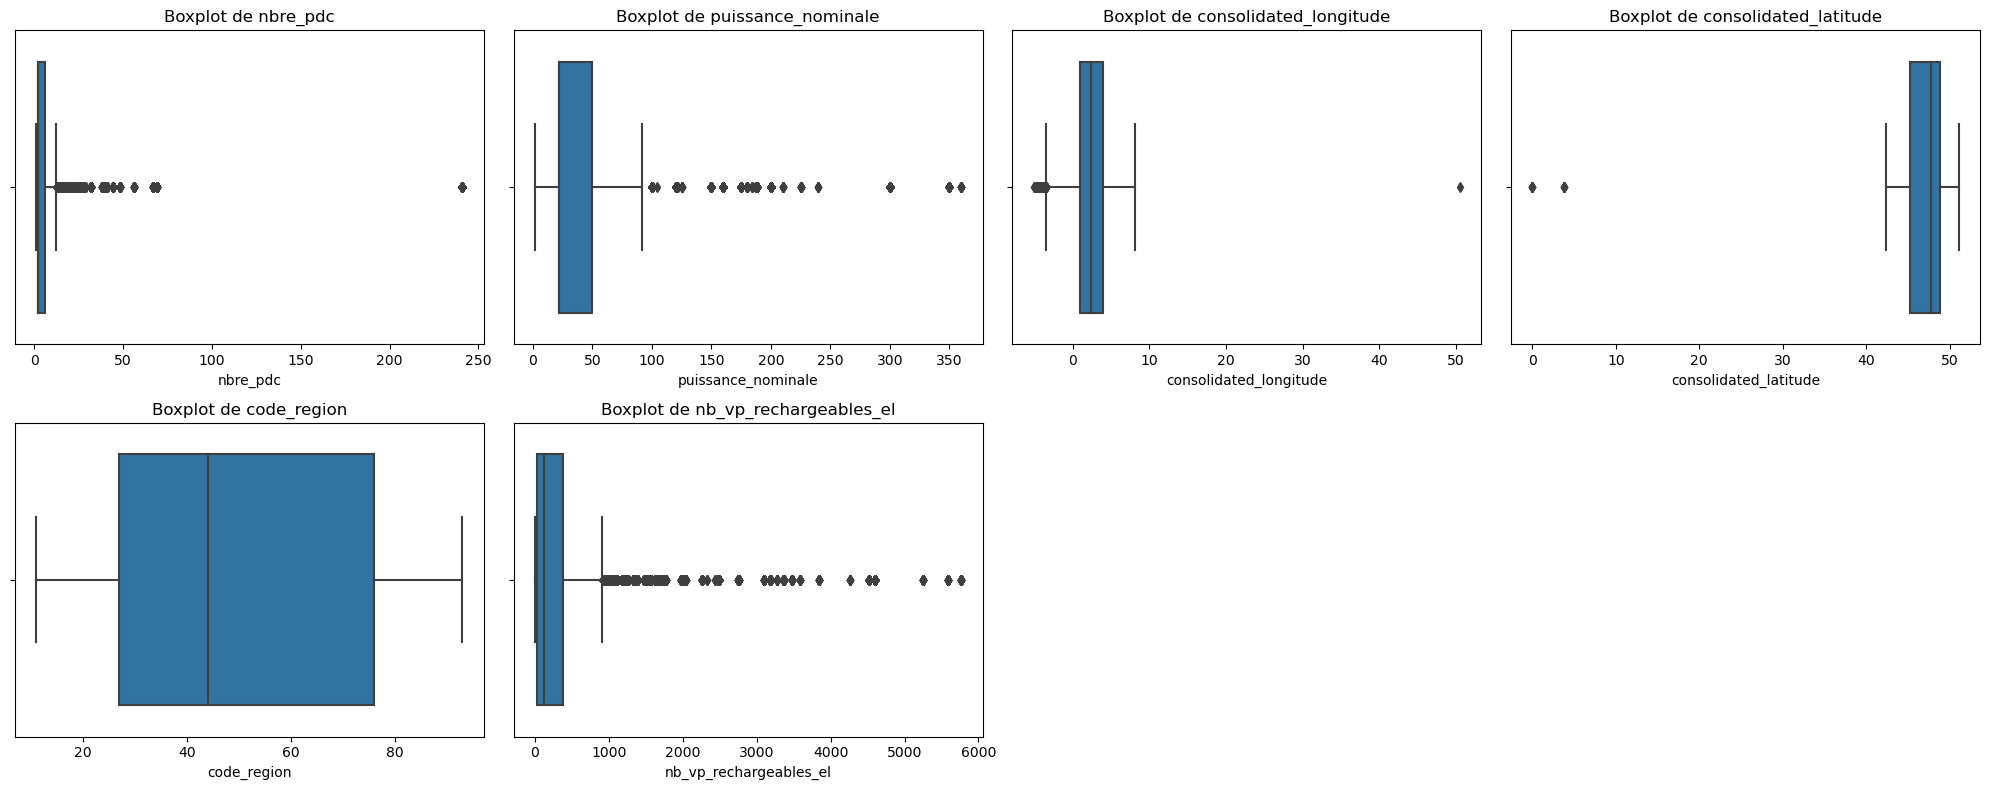

In [37]:


# Exemple : Chargement de votre DataFrame df_final_1
# Assurez-vous d'avoir déjà importé et préparé votre DataFrame df_final_1

# Sélectionner uniquement les colonnes numériques
colonnes_numeriques = df_final_1.select_dtypes(include=['int64', 'float64'])

# Définir le nombre de colonnes pour la grille
num_cols = 4  # Nombre de colonnes dans la grille
num_rows = math.ceil(len(colonnes_numeriques.columns) / num_cols)  # Calculer le nombre de lignes nécessaires

# Définir la taille de la figure en fonction du nombre de colonnes et de lignes
plt.figure(figsize=(20, 4 * num_rows))

# Itérer sur chaque colonne numérique et afficher le boxplot dans un subplot
for i, col in enumerate(colonnes_numeriques.columns):
    plt.subplot(num_rows, num_cols, i + 1)  # Sélectionner le subplot approprié
    sns.boxplot(data=df_final_1, x=col)  # Utiliser df_final_1 comme source de données et spécifier la colonne x
    plt.title(f"Boxplot de {col}")
    plt.xlabel(col)

# Ajuster l'espacement entre les subplots
plt.tight_layout()

# Afficher la figure
plt.show()



In [38]:
df_final_2= df_final_1.copy()

df_final_2 = df_final_2[df_final_2['nbre_pdc'] < 100]

 

In [39]:
df_final_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34630 entries, 0 to 61953
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype              
---  ------                               --------------  -----              
 0   id_station_itinerance                34630 non-null  object             
 1   id_pdc_itinerance                    34630 non-null  object             
 2   nom_station                          34630 non-null  object             
 3   implantation_station                 34630 non-null  object             
 4   code_insee_commune                   34630 non-null  object             
 5   coordonneesXY                        34630 non-null  object             
 6   nbre_pdc                             34630 non-null  int64              
 7   puissance_nominale                   34630 non-null  float64            
 8   date_mise_en_service                 34630 non-null  datetime64[ns]     
 9   date_maj                    

In [40]:


df_final_2.head()

id_station_itinerance id_pdc_itinerance  \
0        FR000011062174    FR000011062174   
1        FR000012292701    FR000012292701   
3        FR000012616553    FR000012616553   
4        FR000028067822    FR000028067822   
5          FR026PYZERON      FR026E169008   

                                    nom_station  \
0                             Hotel saint alban   
1  HÃ´tel Restaurant Campanile Nogent-sur-Marne   
3                                        1PACTE   
4                                Carry-le-Rouet   
5                                        YZERON   

             implantation_station code_insee_commune  \
0  Parking privÃ© Ã  usage public              34199   
1  Parking privÃ© Ã  usage public              94052   
3  Parking privÃ© Ã  usage public              13041   
4  Parking privÃ© Ã  usage public              13021   
5  Parking privÃ© Ã  usage public              69269   

                             coordonneesXY  nbre_pdc  puissance_nominale  \
0   [3.407609123225763, 43.41959147913006]         1                22.0   
1  [2.493569567590577, 48.832677935169805]         2                22.0   
3        [5.476711409891, 43.476583984941]         2                22.0   
4    [5.143766265497639, 43.3292004491334]         2                36.0   
5                    [4.578864, 45.704218]         1                11.0   

  date_mise_en_service   date_maj                    last_modified  \
0           2022-03-02 2022-04-25 2024-01-19 07:47:00.381000+00:00   
1           2022-02-22 2022-05-12 2024-01-19 07:47:00.381000+00:00   
3           2022-04-04 2022-05-04 2024-01-19 07:47:00.381000+00:00   
4           2023-01-13 2023-06-06 2024-01-19 07:48:04.429000+00:00   
5           2023-07-06 2023-07-06 2024-01-19 07:49:07.361000+00:00   

   consolidated_longitude  consolidated_latitude consolidated_code_postal  \
0                3.407609              43.419591                    34120   
1                2.493570              48.832678                    94130   
3                5.476711              43.476584                    13120   
4                5.143766              43.329200                    13620   
5                4.578864              45.704218                    69510   

  consolidated_commune  consolidated_is_lon_lat_correct  \
0             PÃ©zenas                            False   
1     Nogent-sur-Marne                             True   
3             Gardanne                             True   
4       Carry-le-Rouet                             True   
5               Yzeron                             True   

   consolidated_is_code_insee_verified code_departement   nom_departement  \
0                                 True               34           Hérault   
1                                 True               94      Val-de-Marne   
3                                 True               13  Bouches-du-Rhône   
4                                 True               13  Bouches-du-Rhône   
5                                 True               69             Rhône   

   code_region                  nom_region codgeo  nb_vp_rechargeables_el  
0         76.0                   Occitanie  34199              133.357143  
1         11.0               Île-de-France  94052              392.642857  
3         93.0  Provence-Alpes-Côte d'Azur  13041              427.857143  
4         93.0  Provence-Alpes-Côte d'Azur  13021              233.285714  
5         84.0        Auvergne-Rhône-Alpes  69269               13.571429

In [41]:
# from sklearn.preprocessing import MinMaxScaler

# # Sélectionner uniquement les colonnes numériques
# colonnes_numeriques = df_final_2.select_dtypes(include=['int64', 'float64'])

# # Initialiser le MinMaxScaler
# scaler = MinMaxScaler()

# # Normaliser les colonnes numériques
# df_normalized = pd.DataFrame(scaler.fit_transform(colonnes_numeriques), columns=colonnes_numeriques.columns)

# # Concaténer les colonnes numériques normalisées avec les autres colonnes du DataFrame original
# # En conservant les colonnes non numériques inchangées
# for col in df_final_2.columns:
#     if col not in colonnes_numeriques.columns:
#         df_normalized[col] = df_final_2[col]

# # Afficher les premières lignes du DataFrame normalisé
# print(df_normalized.head())


In [42]:
# df_normalized.info()

In [43]:
df_final_3=df_final_2.copy()
df_id=df_final_2.copy()

In [44]:
df_final_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34630 entries, 0 to 61953
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype              
---  ------                               --------------  -----              
 0   id_station_itinerance                34630 non-null  object             
 1   id_pdc_itinerance                    34630 non-null  object             
 2   nom_station                          34630 non-null  object             
 3   implantation_station                 34630 non-null  object             
 4   code_insee_commune                   34630 non-null  object             
 5   coordonneesXY                        34630 non-null  object             
 6   nbre_pdc                             34630 non-null  int64              
 7   puissance_nominale                   34630 non-null  float64            
 8   date_mise_en_service                 34630 non-null  datetime64[ns]     
 9   date_maj                    

In [45]:
# import pandas as pd

# # Suppose df_final_2 est votre DataFrame contenant les données
# # Sélectionner aléatoirement 20% des données pour X_val
# X_val = df_final_2.sample(frac=0.2, random_state=42)  # Utilisation d'une graine aléatoire pour la reproductibilité

# # Afficher les dimensions de X_val
# print("Dimensions de X_val :", X_val.shape)

# # Utilisez X_val comme ensemble de validation dans votre analyse
# # Par exemple, pour diviser votre DataFrame original en ensemble d'entraînement et ensemble de test
# X_train_1 = df_final_2.drop(X_val.index)

# # Afficher les dimensions de X_train
# print("Dimensions de X_train :", X_train_1.shape)

# # Utilisez X_train et X_val dans votre analyse ou votre modèle


In [46]:
# Sélectionner les colonnes "id_station_itinerance" et "id_pdc_itinerance"
df_id = df_final_2[["id_station_itinerance", "id_pdc_itinerance"]]

# Sélectionner les autres colonnes dans un nouveau DataFrame
df_final_3 = df_final_2[["implantation_station", "nbre_pdc", "puissance_nominale",
                         "date_maj", "consolidated_longitude",
                         "consolidated_latitude", "consolidated_commune",
                         "consolidated_is_lon_lat_correct", "nom_region", "nb_vp_rechargeables_el"]]

# Afficher les premières lignes du DataFrame df_id
df_final_3.head()


implantation_station  nbre_pdc  puissance_nominale   date_maj  \
0  Parking privÃ© Ã  usage public         1                22.0 2022-04-25   
1  Parking privÃ© Ã  usage public         2                22.0 2022-05-12   
3  Parking privÃ© Ã  usage public         2                22.0 2022-05-04   
4  Parking privÃ© Ã  usage public         2                36.0 2023-06-06   
5  Parking privÃ© Ã  usage public         1                11.0 2023-07-06   

   consolidated_longitude  consolidated_latitude consolidated_commune  \
0                3.407609              43.419591             PÃ©zenas   
1                2.493570              48.832678     Nogent-sur-Marne   
3                5.476711              43.476584             Gardanne   
4                5.143766              43.329200       Carry-le-Rouet   
5                4.578864              45.704218               Yzeron   

   consolidated_is_lon_lat_correct                  nom_region  \
0                            False                   Occitanie   
1                             True               Île-de-France   
3                             True  Provence-Alpes-Côte d'Azur   
4                             True  Provence-Alpes-Côte d'Azur   
5                             True        Auvergne-Rhône-Alpes   

   nb_vp_rechargeables_el  
0              133.357143  
1              392.642857  
3              427.857143  
4              233.285714  
5               13.571429

In [47]:
df_final_3['annee'] = df_final_3['date_maj'].dt.year
df_final_3['mois'] = df_final_3['date_maj'].dt.month
df_final_3['jour_semaine'] = df_final_3['date_maj'].dt.dayofweek

df_final_3= df_final_3[['implantation_station', 'nbre_pdc', 'puissance_nominale',
       'consolidated_longitude', 'consolidated_latitude',
       'consolidated_commune', 'consolidated_is_lon_lat_correct', 'nom_region',
       'nb_vp_rechargeables_el','annee','mois','jour_semaine']]



C:\Users\khaled\AppData\Local\Temp\ipykernel_10484\3735033315.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_3['annee'] = df_final_3['date_maj'].dt.year
C:\Users\khaled\AppData\Local\Temp\ipykernel_10484\3735033315.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_3['mois'] = df_final_3['date_maj'].dt.month
C:\Users\khaled\AppData\Local\Temp\ipykernel_10484\3735033315.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [48]:
df_final_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34630 entries, 0 to 61953
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   implantation_station             34630 non-null  object 
 1   nbre_pdc                         34630 non-null  int64  
 2   puissance_nominale               34630 non-null  float64
 3   consolidated_longitude           34630 non-null  float64
 4   consolidated_latitude            34630 non-null  float64
 5   consolidated_commune             34630 non-null  object 
 6   consolidated_is_lon_lat_correct  34630 non-null  bool   
 7   nom_region                       34630 non-null  object 
 8   nb_vp_rechargeables_el           34630 non-null  float64
 9   annee                            34630 non-null  int64  
 10  mois                             34630 non-null  int64  
 11  jour_semaine                     34630 non-null  int64  
dtypes: bool(1), float6

In [49]:


# Sélectionner les colonnes numériques à normaliser
colonnes_num = ['puissance_nominale', 'nb_vp_rechargeables_el', 
                'consolidated_longitude', 'consolidated_latitude','annee','mois','jour_semaine']

# Créer un DataFrame avec les colonnes numériques
df_features = df_final_3[colonnes_num].copy()

# Normaliser les données avec MinMaxScaler
scaler = MinMaxScaler()
df_features = scaler.fit_transform(df_features)

# Remplacer les colonnes d'origine par les colonnes normalisées
df_final_3[colonnes_num] = df_features

# Afficher les premières lignes du DataFrame avec les colonnes normalisées
df_final_3.head()

# nbre_pdc

implantation_station  nbre_pdc  puissance_nominale  \
0  Parking privÃ© Ã  usage public         1            0.056656   
1  Parking privÃ© Ã  usage public         2            0.056656   
3  Parking privÃ© Ã  usage public         2            0.056656   
4  Parking privÃ© Ã  usage public         2            0.095730   
5  Parking privÃ© Ã  usage public         1            0.025956   

   consolidated_longitude  consolidated_latitude consolidated_commune  \
0                0.152987               0.850312             PÃ©zenas   
1                0.136545               0.956320     Nogent-sur-Marne   
3                0.190206               0.851428             Gardanne   
4                0.184217               0.848542       Carry-le-Rouet   
5                0.174056               0.895053               Yzeron   

   consolidated_is_lon_lat_correct                  nom_region  \
0                            False                   Occitanie   
1                             True               Île-de-France   
3                             True  Provence-Alpes-Côte d'Azur   
4                             True  Provence-Alpes-Côte d'Azur   
5                             True        Auvergne-Rhône-Alpes   

   nb_vp_rechargeables_el     annee      mois  jour_semaine  
0                0.023112  0.833333  0.272727      0.000000  
1                0.068071  0.833333  0.363636      0.500000  
3                0.074177  0.833333  0.363636      0.333333  
4                0.040439  0.916667  0.454545      0.166667  
5                0.002341  0.916667  0.545455      0.500000

In [50]:
df_final_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34630 entries, 0 to 61953
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   implantation_station             34630 non-null  object 
 1   nbre_pdc                         34630 non-null  int64  
 2   puissance_nominale               34630 non-null  float64
 3   consolidated_longitude           34630 non-null  float64
 4   consolidated_latitude            34630 non-null  float64
 5   consolidated_commune             34630 non-null  object 
 6   consolidated_is_lon_lat_correct  34630 non-null  bool   
 7   nom_region                       34630 non-null  object 
 8   nb_vp_rechargeables_el           34630 non-null  float64
 9   annee                            34630 non-null  float64
 10  mois                             34630 non-null  float64
 11  jour_semaine                     34630 non-null  float64
dtypes: bool(1), float6

In [51]:
import pandas as pd

# Supposons que df_final_2 est votre DataFrame
# Identifier les colonnes catégorielles
colonnes_categorielles = df_final_3.select_dtypes(include=['object','bool']).columns

# Encoder les colonnes catégorielles avec pd.get_dummies()
df_encoded = pd.get_dummies(df_final_3, columns=colonnes_categorielles)

# Afficher les premières lignes du DataFrame encodé
df_encoded.head(20)


nbre_pdc  puissance_nominale  consolidated_longitude  \
0          1            0.056656                0.152987   
1          2            0.056656                0.136545   
3          2            0.056656                0.190206   
4          2            0.095730                0.184217   
5          1            0.025956                0.174056   
6          1            0.056656                0.149384   
7          1            0.056656                0.149383   
8          1            0.056656                0.149380   
9          1            0.056656                0.149385   
10         1            0.056656                0.131486   
11         1            0.056656                0.149384   
12         1            0.056656                0.149379   
13         1            0.056656                0.149385   
14         1            0.056656                0.149382   
15         1            0.056656                0.149378   
16         1            0.056656                0.149386   
17         1            0.056656                0.149386   
18         2            0.056656                0.142036   
19         1            0.056656                0.131486   
20         2            0.056656                0.142036   

    consolidated_latitude  nb_vp_rechargeables_el     annee      mois  \
0                0.850312                0.023112  0.833333  0.272727   
1                0.956320                0.068071  0.833333  0.363636   
3                0.851428                0.074177  0.833333  0.363636   
4                0.848542                0.040439  0.916667  0.454545   
5                0.895053                0.002341  0.916667  0.545455   
6                0.992593                0.110455  0.833333  0.545455   
7                0.992594                0.110455  0.833333  0.545455   
8                0.992595                0.110455  0.833333  0.545455   
9                0.992593                0.110455  0.833333  0.545455   
10               0.958252                0.057184  0.833333  0.545455   
11               0.992593                0.110455  0.833333  0.545455   
12               0.992595                0.110455  0.833333  0.545455   
13               0.992593                0.110455  0.833333  0.545455   
14               0.992594                0.110455  0.833333  0.545455   
15               0.992596                0.110455  0.833333  0.545455   
16               0.992593                0.110455  0.833333  0.545455   
17               0.992593                0.110455  0.833333  0.545455   
18               0.956483                0.032834  0.833333  0.545455   
19               0.958253                0.057184  0.833333  0.545455   
20               0.956483                0.032834  0.833333  0.545455   

    jour_semaine  \
0       0.000000   
1       0.500000   
3       0.333333   
4       0.166667   
5       0.500000   
6       0.500000   
7       0.500000   
8       0.500000   
9       0.500000   
10      0.500000   
11      0.500000   
12      0.500000   
13      0.500000   
14      0.500000   
15      0.500000   
16      0.500000   
17      0.500000   
18      0.500000   
19      0.500000   
20      0.500000   

    implantation_station_Parking privÃ© rÃ©servÃ© Ã  la clientÃ¨le  \
0                                                   0                
1                                                   0                
3                                                   0                
4                                                   0                
5                                                   0                
6                                                   0                
7                                                   0                
8                                                   0                
9                                                   0                
10                                                  0                
11                

In [52]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34630 entries, 0 to 61953
Columns: 4929 entries, nbre_pdc to nom_region_Île-de-France
dtypes: float64(7), int64(1), uint8(4921)
memory usage: 164.9 MB


##modeledeep learning

c:\ProgramData\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
866/866 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 43.9297 - val_loss: 11.3079
Epoch 2/50
866/866 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 9.3994 - val_loss: 8.8100
Epoch 3/50
866/866 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7.9576 - val_loss: 7.8899
Epoch 4/50
866/866 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 7.2691 - val_loss: 7.2940
Epoch 5/50
866/866 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 7.1062 - val_loss: 7.6506
Epoch 6/50
866/866 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 7.2149 - val_loss: 6.8501
Epoch 7/50
866/866 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7.1634 - val_loss: 7.2789
Epoch 8/50
866/866 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 6.3647 - val_loss: 6.9485
Epoch 9/50
866/866 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 6.1530 - val_loss: 6.8004
Epoch 10/50
866/866 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.3424 - val_loss: 6.9536
Epoch 11/50
866/866 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 6.4510 - val_loss: 6.5820
Epoch 12/50
866/866 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/st

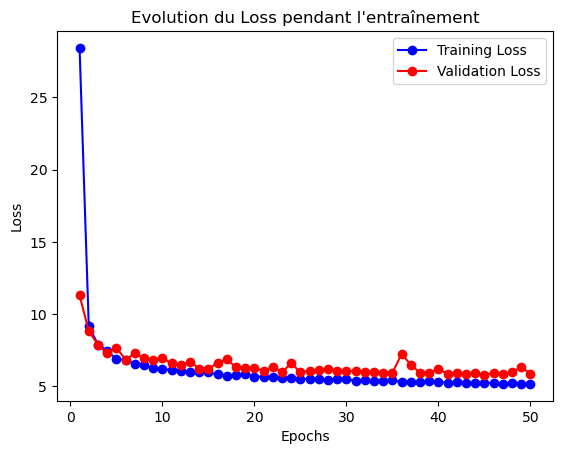

Meilleur score (Loss le plus petit) sur les données de validation : 5.794626712799072
Loss final sur les données d'entraînement à la dernière époque : 5.185016632080078
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 1s 851us/step


In [53]:


# Séparation des features et de la target
features = df_encoded.drop('nbre_pdc', axis=1)
target = df_encoded['nbre_pdc']

# Division des données en ensembles d'entraînement et de test
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

# Définition du modèle de deep learning
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(features.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  # Couche de sortie pour la régression
])

# Compilation du modèle
model.compile(optimizer='adam', loss='mse')  # Utilisation de MSE comme fonction de perte pour la régression

# Entraînement du modèle avec sauvegarde de l'historique
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Extraction des valeurs de loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Tracer la courbe d'évolution du loss
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Evolution du Loss pendant l\'entraînement')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Affichage du meilleur score et du loss le plus petit
best_score = min(history.history['val_loss'])  # Meilleur loss sur les données de validation
final_loss = train_loss[-1]  # Loss final sur les données d'entraînement à la dernière époque

print(f"Meilleur score (Loss le plus petit) sur les données de validation : {best_score}")
print(f"Loss final sur les données d'entraînement à la dernière époque : {final_loss}")

# Faire des prédictions sur l'ensemble de validation
y_pred = model.predict(features)

# Créer un DataFrame avec les prédictions et les valeurs réelles
# predictions_df = pd.DataFrame({'Prediction': y_pred.flatten(), 'Real Value': y_val.values})
# Créer un DataFrame avec les identifiants, les données originales et les prédictions
df_predictions = pd.concat([df_final_2, pd.Series(y_pred.flatten(), name='Prediction')], axis=1)



# Enregistrer le DataFrame dans un fichier CSV
df_predictions.to_csv('data/predictions.csv', index=False)


In [54]:
df_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54000 entries, 0 to 34493
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype              
---  ------                               --------------  -----              
 0   id_station_itinerance                34630 non-null  object             
 1   id_pdc_itinerance                    34630 non-null  object             
 2   nom_station                          34630 non-null  object             
 3   implantation_station                 34630 non-null  object             
 4   code_insee_commune                   34630 non-null  object             
 5   coordonneesXY                        34630 non-null  object             
 6   nbre_pdc                             34630 non-null  float64            
 7   puissance_nominale                   34630 non-null  float64            
 8   date_mise_en_service                 34630 non-null  datetime64[ns]     
 9   date_maj                    